
# **Slot Machine**<br>
If you are using BigQuery with the on demand billing model where you are billed by bytes scanned, it may be a good idea to switch to the Editions model where you are billed for slots you used.

There are Two quite complicated querstions though:


1.   Will moving to Editions save me money ?
2.   How many slots should I reserve, what is the optimal max_xlots value ?

There is no way to be 100% accurate, but this set of queries aims to reduce the guesswork and guide you in finding better answers to the Two questions above.





**Usage**<br>
You should run this in the project you want to test.
The process creates several tables and views, if any of them already exists then it will stop with error, since we don't want to accidently delete user's important tables.

**Step 1**<br>
First we set some parameters such as region, timeframe and BigQuery edition. We also detect the current project id.

Here is a short description of the parameters:

- **region**: The region where your dataset is located. INFORMATION_SCHEMA is a regional data source.
- **dataset**: the dataset where you want the tables and views related to slot machine to be created. It's a good idea to create a dedicated dataset so we won't accidently overwrite a production table or view.
- **start and end timestamp**: We analyze the behavior in a limited timeframe. It should be long enough to contain all regular activity so it should contain at lease few days.
- **edition**: BigQuery compute has Three editions when using reservations which are priced differently. Choosing the edition affects total price and available features. You can read more [here](https://cloud.google.com/bigquery/docs/editions-intro).
- **verbose**: If true, Slot machine will print out the queries it runs plus additional interim data. If false it will operate quietly without printing out every query and interim result.

In [28]:
import google.auth
project_id = google.auth.default()[1]
region = "US" # @param {"type":"string", "placeholder": "Enter dataset region"}
dataset = "test2" # @param {"type":"string", "placeholder": "Enter the target dataset where objects will be created"}
start_timestamp = "2024-09-23" # @param {"type":"date"}
end_timestamp = "2024-09-30" # @param {"type":"date"}
edition = "Standard" # @param ["Standard", "Enterprise", "Enterprise plus"]
verbose = True # @param {"type":"boolean"}

**Step 2**<br>
Here we import some python packages and create the dataset if it does not already exist.

In [2]:
import pandas as pd
from google.cloud import bigquery
from google.cloud.exceptions import NotFound

client = bigquery.Client()
my_dataset = bigquery.Dataset(project_id+"."+dataset)
my_dataset.location = region


try:
    client.get_dataset(project_id+"."+dataset)
    print("Dataset {} already exists".format(dataset))
except NotFound:
    print("Dataset {} is not found".format(dataset), "creating it.")
    dataset_object = client.create_dataset(my_dataset, timeout=30)

Dataset test2 already exists


**Step 3**<br>
Ceate a table with the on demand consumption for reference. The table name is bytes.<br>
We select from INFORMATION_SCHEMA.JOBS to find the total bytes billed during the timeframe and what was the cost in USD.<br>Write down the result.

In [3]:
print(dataset)
query = "create table "+dataset+".bytes as "+"""SELECT
  SUM(total_bytes_billed/1024/1024/1024/1024) AS total_tb_billed,
  SUM(total_bytes_billed/1024/1024/1024/1024)*6.25 as cost_usd
FROM """+project_id+".region-"+region+""".INFORMATION_SCHEMA.JOBS
WHERE
  creation_time BETWEEN CAST(\""""+start_timestamp+"""\" AS TIMESTAMP)
  AND """+"CAST(\""+end_timestamp+"\" AS TIMESTAMP)"

if verbose:
  print(query)

df = pd.io.gbq.read_gbq(query=query, project_id=project_id, dialect='standard')

test2


**Step 4**<br>
Then we query INFORMATION_SCHEMA.JOBS_TIMELINE on the same time range to see how many slots were used in every second of the time range. We send the result to a table called slots.

In [4]:
query = "create table "+dataset+".slots as "+"""SELECT
  period_start,
  SUM(period_slot_ms/1000) AS total_slot_ms,
FROM
  """+project_id+".region-"+region+""".INFORMATION_SCHEMA.JOBS_TIMELINE
WHERE
  period_start BETWEEN CAST(\""""+start_timestamp+"""\" AS TIMESTAMP)
  AND """+"CAST(\""+end_timestamp+"\" AS TIMESTAMP)"""

query = query + """
GROUP BY
  period_start
ORDER BY
  period_start DESC"""

if verbose:
  print(query)
df = pd.io.gbq.read_gbq(query=query, project_id=project_id, dialect='standard')

TableCreationError: Reason: Already Exists: Table nexite-434614:test2.slots

**Step 5**<br>
We create a dynamic query that creates buckets incremented by 50 from 0 to the highest number of slots used during the selected time period.<br>
The original time periods are seconds, so we aggregate the data in Minute granularity and for each minute we take the high<br> watermark of slot usage (since BigQuery autoscaler's minimum is 1 minute).<br><br>
Then we assign each minute to a specific bucket according to the maximum slots that ut used.<br>
We create a view called bucketed to hold the result and enable further calculations.

In [32]:
query1 = "select max(total_slot_ms) as max_slots from "+dataset+".slots"
df = pd.io.gbq.read_gbq(query=query1, project_id=project_id, dialect='standard')
max_slots = int(df._get_value(0, 'max_slots'))
query2 = "create view "+dataset+".bucketed"+""" as SELECT
  period_start,
  (case
when total_slot_ms = 0 then 0\n"""
for i in range(0, max_slots, 50):
  line = "when total_slot_ms between "+str(i)+" and "+str(i+50)+" then "+str(i+50)+'\n'
  query2 = query2 + line
query2 = query2 + """  end) as bucket
FROM """+dataset+".slots"

if verbose:
  print(query2)

df = pd.io.gbq.read_gbq(query=query2, project_id=project_id, dialect='standard')

create view test2.bucketed as SELECT
  period_start,
  (case
when total_slot_ms = 0 then 0
when total_slot_ms between 0 and 50 then 50
when total_slot_ms between 50 and 100 then 100
when total_slot_ms between 100 and 150 then 150
when total_slot_ms between 150 and 200 then 200
when total_slot_ms between 200 and 250 then 250
when total_slot_ms between 250 and 300 then 300
when total_slot_ms between 300 and 350 then 350
when total_slot_ms between 350 and 400 then 400
when total_slot_ms between 400 and 450 then 450
when total_slot_ms between 450 and 500 then 500
when total_slot_ms between 500 and 550 then 550
when total_slot_ms between 550 and 600 then 600
when total_slot_ms between 600 and 650 then 650
when total_slot_ms between 650 and 700 then 700
when total_slot_ms between 700 and 750 then 750
when total_slot_ms between 750 and 800 then 800
when total_slot_ms between 800 and 850 then 850
when total_slot_ms between 850 and 900 then 900
when total_slot_ms between 900 and 950 then 950
wh

**Step 6**<br>
Here we create a view called buckets_count that shows hoe many time periods (minutes) fall into each bucket.<br>
Then we print the contents of the view.

In [34]:
query = "create view "+dataset+""".buckets_count as SELECT
  bucket,
  COUNT(*) as periods,
FROM `"""+project_id+"."+dataset+""".bucketed`
where bucket is not null
GROUP BY
  bucket"""

if verbose:
  print(query)

df = pd.io.gbq.read_gbq(query=query, project_id=project_id, dialect='standard')
query = 'select * from '+dataset+".buckets_count order by bucket"

if verbose:
  print(query)
df = pd.io.gbq.read_gbq(query=query, project_id=project_id, dialect='standard')
print(df)

create view test2.buckets_count as SELECT
  bucket,
  COUNT(*) as periods,
FROM `nexite-434614.test2.bucketed`
where bucket is not null
GROUP BY
  bucket
select * from test2.buckets_count order by bucket
    bucket  periods
0        0       76
1       50     1568
2      100      427
3      150      277
4      200      127
5      250       53
6      300       42
7      350       48
8      400       84
9      450       86
10     500       76
11     550      146
12     600      140
13     650      106
14     700       76
15     750       78
16     800       49
17     850       77
18     900       92
19     950      115
20    1000      595
21    1050      887
22    1100       21
23    1150        2


For our next calculations we need to know Two numbers:


1.   How many hours there are in our timeframe
2.   How many time periods we have

So steps 7 and 8 find those values.





**Step 7**<br>
Calculate how many hours we have in the chosen time frame.

In [35]:
from datetime import datetime
date_format = '%Y-%m-%d'
diff = datetime.strptime(end_timestamp,date_format) - datetime.strptime(start_timestamp, date_format)
hours = diff.days * 24 + diff.seconds / 3600
if verbose:
  print("hours: "+str(hours))

hours: 168.0


**Step 8**<br>
Calculate how many time slots we have.

In [36]:
query = "select count(*) as periods from "+dataset+".bucketed"
df = pd.io.gbq.read_gbq(query=query, project_id=project_id, dialect='standard')
periods = df._get_value(0, 'periods')
if verbose:
  print("periods: "+str(periods))

periods: 5248


**Step 9**<br>
This is the heart of our calculation.<br><br>
We know how many hours were in the selected timeframe and how many time periods we had during this timeframe.
So we can calculate what is the percentage of all the time that we used each bucket.<br>
If we know the percentage of time and we know how many wours we had in the timeframe then we can calculate how many hours each bucket was active.<br>
And we know how much each slot/hour costs for each BigQuery edition so we can calculate the cost each bucket incured.

So here we create a view called calculated that holds the bucket, the percentage of all time that this bucket was used, how many hours it was used, and how much we would be charged for it if we use the selected edition.

In [38]:
if edition == 'Enterprise':
  price = 0.06
elif edition == 'Enterprise plus':
  price = 0.1
else:
  price = 0.04

query = "create view "+dataset+""".calculated as SELECT
  bucket,
  round(periods/"""+str(periods)+"""*100, 3) as percentage,
  round(periods/"""+str(periods)+"*100/100*"+str(hours)+""", 3) as hours,
  round(periods/"""+str(periods)+"*100/100*"+str(hours)+"*bucket*"+str(price)+""", 3) as cost_usd
FROM
  `"""+project_id+"."+dataset+""".buckets_count`
  order by bucket"""

if verbose:
  print(query)

df = pd.io.gbq.read_gbq(query=query, project_id=project_id, dialect='standard')

create view test2.calculated as SELECT
  bucket,
  round(periods/5248*100, 3) as percentage,
  round(periods/5248*100/100*168.0, 3) as hours,
  round(periods/5248*100/100*168.0*bucket*0.04, 3) as cost_usd
FROM
  `nexite-434614.test2.buckets_count`
  order by bucket


**Let's see how it looks like.**

In [39]:
query = "select * from "+dataset+".calculated"
calculated = pd.io.gbq.read_gbq(query=query, project_id=project_id, dialect='standard')

In [40]:
print(calculated)

    bucket  percentage   hours  cost_usd
0        0       1.448   2.433     0.000
1       50      29.878  50.195   100.390
2      100       8.136  13.669    54.677
3      150       5.278   8.867    53.204
4      200       2.420   4.066    32.524
5      250       1.010   1.697    16.966
6      300       0.800   1.345    16.134
7      350       0.915   1.537    21.512
8      400       1.601   2.689    43.024
9      450       1.639   2.753    49.555
10     500       1.448   2.433    48.659
11     550       2.782   4.674   102.823
12     600       2.668   4.482   107.561
13     650       2.020   3.393    88.226
14     700       1.448   2.433    68.122
15     750       1.486   2.497    74.909
16     800       0.934   1.569    50.195
17     850       1.467   2.465    83.808
18     900       1.753   2.945   106.024
19     950       2.191   3.681   139.893
20    1000      11.338  19.047   761.890
21    1050      16.902  28.395  1192.582
22    1100       0.400   0.672    29.579
23    1150      

**Stage 10**<br>
Here is a visualization of the histogram that shows the distribution of the slot buckets and the time spent in each of them.<br>
There should be a "sweet spot" where most of the buckets under it are heavily used and above it there is only slight usage.<br>
This shhould give you the sense of where that sweet spot should be.

<Axes: xlabel='bucket'>

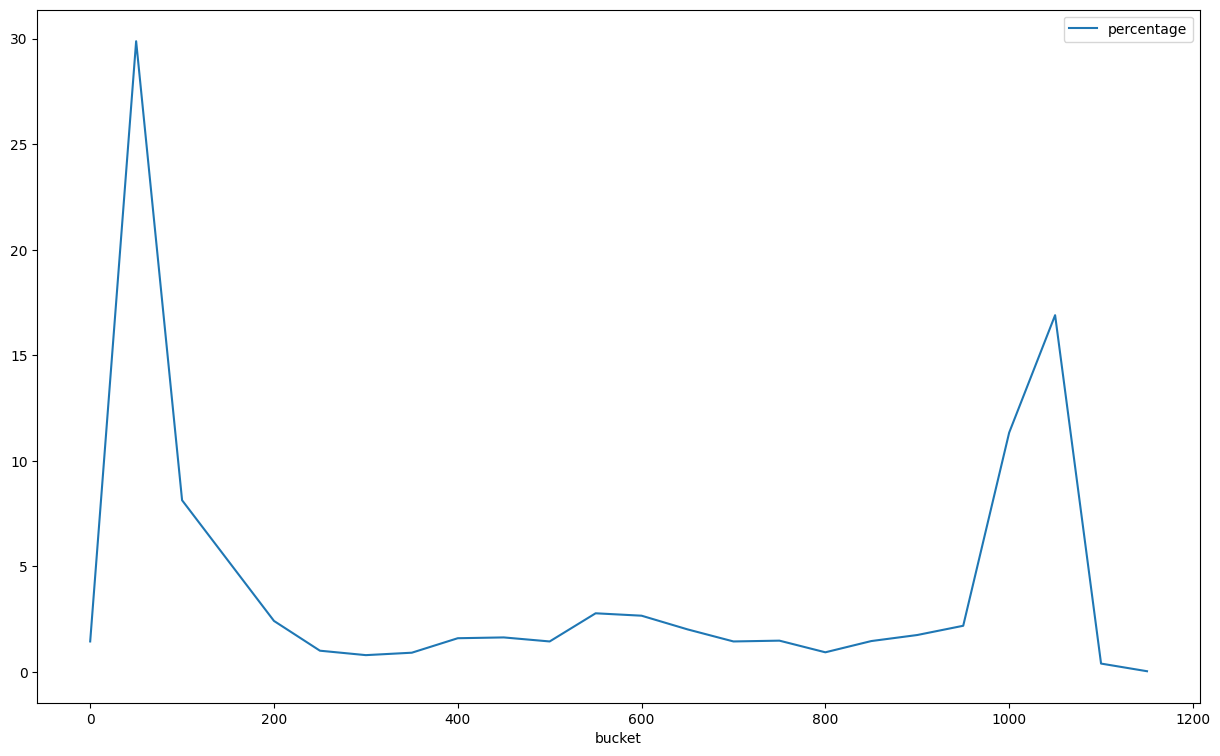

In [41]:
import pandas as pd
import matplotlib.pyplot as plt

calculated.plot(x="bucket", y="percentage", kind="line",figsize=(15,9))

<Axes: xlabel='period_start'>

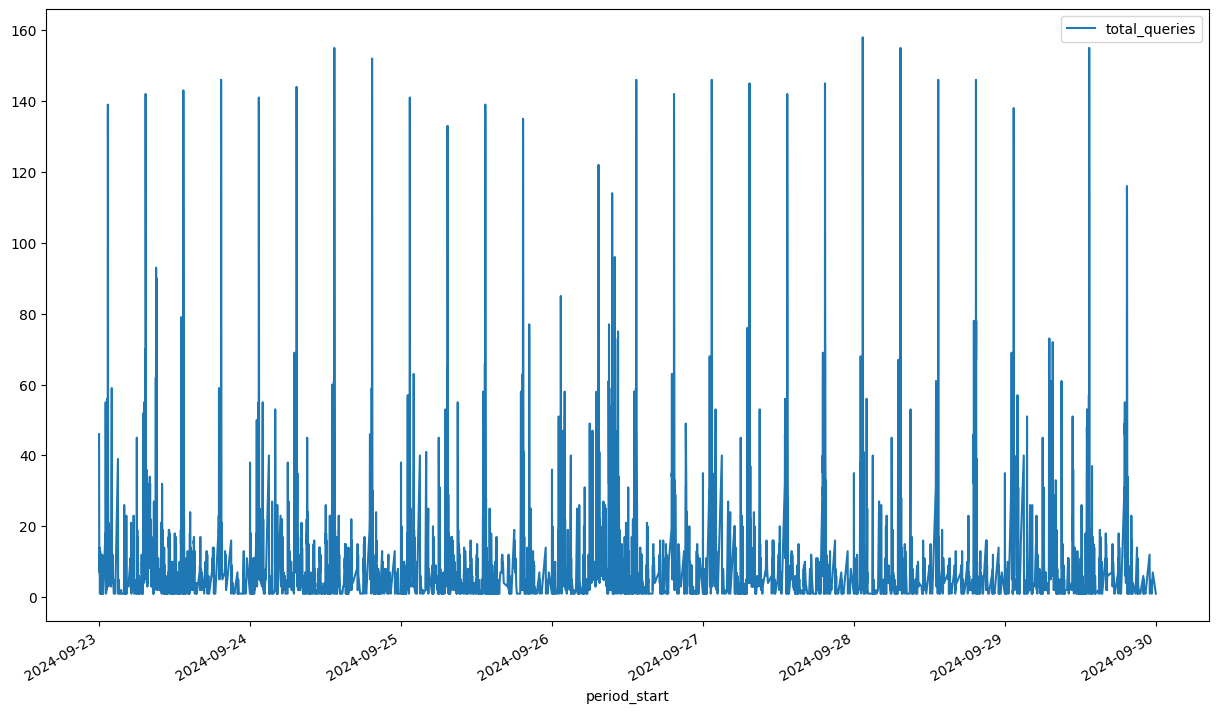

In [50]:
query = "select period_start, total_queries from "+dataset+".slots order by period_start"
df = pd.io.gbq.read_gbq(query=query, project_id=project_id, dialect='standard')
df.plot(x="period_start", y="total_queries", kind="line",figsize=(15,9))
#ts = pd.Series(df[total_queries], index=pd.period_start)

#ts = ts.cumsum()
#ts.plot()

**Step 11**<br>
Use the following query to identify where slot usage drops below 1% of the time.

In [42]:
query = "select max(bucket) as recommended from "+dataset+".calculated where percentage > 1"

if verbose:
  print(query)

df = pd.io.gbq.read_gbq(query=query, project_id=project_id, dialect='standard')
print(df)

select max(bucket) as recommended from test2.calculated where percentage > 1
   recommended
0         1050


**Step 12**<br>
The following steps try to find the optimal max_slots that best balances cost and performance.<br>
As a first step choose the max_slots value you want to check.

In [ ]:
max_slots = 750 # @param {"type":"number"}

**Explanation**<br>
The trade off is cost vs. performance. If we choose the right max_slots than we can reduce the cost while only a small number of queries will decrease in performance. If these are not time critical queries (such as ETLs, background jobs etc.) than we may want to "sacrifice" them in return for  lower cost.

**Step 13**<br>
We try to calculate how much will we pay if we choose the above max_slots.<br>
This is a naive approach as it does not take into consideration all the buckers above the max_slots, as they all had 0 percent.

In [ ]:
answer = calculated[calculated['bucket'] <= max_slots]
summed = answer['cost_usd'].sum()
print('Total cost estimation for the time frame using maximum slots '+str(max_slots)+' is '+str(summed)+' USD.' )

Total cost estimation for the time frame using maximum slots 750 is 8320.493999999999 USD.


**Step 14**<br>
Finally, we want to see which queries will be the most affected by the slot decrease (the ones that has slot consumption above max_slots).
Many times you find out that those queries are not time sensitive (such as background processes) and you can sacrifice their performance to lower cost.

In [ ]:
query = """SELECT
  *
FROM (
  SELECT
    timeline.job_id AS job_id,
    jobs.query AS query,
    jobs.job_type AS job_type,
    ROUND(MAX(timeline.period_slot_ms/1000)) AS total_slot_ms,
    COUNT(timeline.job_id) AS slices
  FROM
    `"""+project_id+"`.`region-"+region+"""`.INFORMATION_SCHEMA.JOBS_TIMELINE AS timeline
  JOIN
    `"""+project_id+"`.`region-"+region+"""`.INFORMATION_SCHEMA.JOBS AS jobs
  ON
    timeline.job_id = jobs.job_id
  WHERE
    period_start BETWEEN CAST(\""""+start_timestamp+"""\" AS TIMESTAMP)
  AND """+"CAST(\""+end_timestamp+"\" AS TIMESTAMP)"""+"""
  GROUP BY
    job_id,
    query,
    job_type
  ORDER BY
    slices DESC)
WHERE
  total_slot_ms>"""+str(max_slots)

if verbose:
  print(query)

df = pd.io.gbq.read_gbq(query=query, project_id=project_id, dialect='standard')
print(df)


SELECT
  *
FROM (
  SELECT
    timeline.job_id AS job_id,
    jobs.query AS query,
    jobs.job_type AS job_type,
    ROUND(MAX(timeline.period_slot_ms/1000)) AS total_slot_ms,
    COUNT(timeline.job_id) AS slices
  FROM
    `superplay-437309`.`region-US`.INFORMATION_SCHEMA.JOBS_TIMELINE AS timeline
  JOIN
    `superplay-437309`.`region-US`.INFORMATION_SCHEMA.JOBS AS jobs
  ON
    timeline.job_id = jobs.job_id
  WHERE
    period_start BETWEEN CAST("2024-09-23" AS TIMESTAMP)
  AND CAST("2024-09-30" AS TIMESTAMP)
  GROUP BY
    job_id,
    query,
    job_type
  ORDER BY
    slices DESC)
WHERE
  total_slot_ms>750
Empty DataFrame
Columns: [job_id, query, job_type, total_slot_ms, slices]
Index: []


**Step 15**

Here we calculate what is the optimal baseline slots value, if any.

In [ ]:
query = """SELECT
  bucket,
  cost_usd,
  MAX(percentage) AS percentage
FROM
  """+dataset+""".calculated
WHERE
  percentage>60
GROUP BY
  bucket, cost_usd"""

if verbose:
  print(query)

df = pd.io.gbq.read_gbq(query=query, project_id=project_id, dialect='standard')
if df.empty:
  print('It is recommended not to set a baseline.')
else:
  bucket = df['bucket'][0]
  cost = df['cost_usd'][0]
  percentage = df['percentage'][0]
  if percentage>60 :
    print("Setting a baseline of "+str(bucket)+" with 3 Year commitment will save you "+str(cost*0.4)+" dollars for the tested period.")
  if percentage>80 :
    print("Setting a baseline of "+str(bucket)+" with 1 Year commitment will save you "+str(cost*0.2)+" dollars for the tested period.")

**Step 16**<br>
Cleanup

In [ ]:
queries = []
queries.append("drop view "+dataset+".calculated")
queries.append("drop view "+dataset+".buckets_count")
queries.append("drop view "+dataset+".bucketed")
queries.append("drop table "+dataset+".bytes")
queries.append("drop table "+dataset+".slots")

for query in queries:
  df = pd.io.gbq.read_gbq(query=query, project_id=project_id, dialect='standard')

print ("Delete complete.")

Delete complete.
